## Artificial Intelligence: Sokoban solver

Author: Alexandru Sima (332CA)


## Prerequisites


### Imports


In [1]:
from random import seed

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from search_methods.beam_search import BeamSearch
from search_methods.lrtastar import LRTAstar
from search_methods.solution import Solution
from search_methods.solver import Solver
from search_methods.utils import get_neighbours_no_pulls, get_neighbours, save_play
from sokoban.map import Map

import search_methods.heuristics as heuristics

### Seeds


In [3]:
SEED = 42

seed(SEED)
np.random.seed(SEED)

### Test levels


In [4]:
tests = [
    "easy_map1",
    "easy_map2",
    "medium_map1",
    "medium_map2",
    "large_map1",
    "large_map2",
    "hard_map1",
    "hard_map2",
    # "super_hard_map1",
]

test_names = [t.replace("_map", " ").replace("_", " ").capitalize() for t in tests]

### Test runner


In [5]:
def run_tests(
    tests: list[str],
    beam_search_solver: BeamSearch,
    astar_solver: LRTAstar | None,
    show_output: bool = True,
) -> tuple[list[Solution], list[Solution]]:
    """Run tests for the given solvers on the specified maps."""
    beam_search_solutions = []
    astar_solutions = []

    for test in tests:
        playmap = Map.from_yaml(f"tests/{test}.yaml")
        if show_output:
            print(f"Running test: {test}")

        if beam_search_solver is not None:
            stats = beam_search_solver.solve(playmap)
            beam_search_solutions.append(stats)
            if show_output:
                print("\tBeam Search Solution:")
                print("\t\t" + str(stats))

        if astar_solver is not None:
            stats = astar_solver.solve(playmap)
            astar_solutions.append(stats)
            if show_output:
                print("\tA* Solution:")
                print("\t\t" + str(stats))

        if show_output:
            playmap.plot_map()

    return beam_search_solutions, astar_solutions

### Plotting


In [6]:
def plot_bars(
    title: str,
    tests: list[str],
    values: list[list[float]],
    legend: list[str],
    ylabel: str,
    fmt="%.2f",
    width=0.25,
):
    """
    Create a bar plot with two bars (beam search and a* results) for each test.
    """

    def compute_bar_offsets(bar_width: float, bar_count: int) -> np.ndarray:
        if bar_count % 2 == 0:
            offsets = np.arange(bar_count // 2, dtype=float)
            offsets = 1 + 2 * offsets
            offsets *= bar_width / 2
            return np.concatenate([-offsets, offsets])

        offsets = np.arange(bar_count // 2, dtype=float)
        offsets = 1 + offsets
        offsets *= bar_width
        return np.concatenate([-offsets, [0], offsets])

    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(tests))
    xoffsets = compute_bar_offsets(width, len(values))

    for label, ys, offset in zip(legend, values, xoffsets):
        bar = ax.bar(x + offset, ys, width, label=label)
        ax.bar_label(bar, fmt=fmt)

    ax.set_xticks(x, tests)
    ax.set_ylabel(ylabel)

    ax.set_title(title)
    ax.legend()

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

### Stats


##### Maps solved


In [7]:
def plot_solved_tests(
    solutions: list[list[Solution]],
    tests: list[str],
    title: str = "Number of solved tests by algorithm",
    width: float = 0.25,
):

    solved_tests = [sum([1 if s.is_solved() else 0 for s in ss]) for ss in solutions]

    _, ax = plt.subplots()
    ax.bar(tests, solved_tests, width=width)

    ax.set_title(title)

    ax.set_xticks(tests)
    ax.set_ylabel("number of solved tests")

    plt.tight_layout()
    plt.show()

##### Time taken


In [8]:
def plot_time(
    tests: list[str],
    solutions: list[list[Solution]],
    names: list[str],
    title: str = "Time taken by each algorithm",
):
    plot_bars(
        title,
        tests,
        [[s.time for s in ss] for ss in solutions],
        names,
        "time (s)",
    )

##### Expanded states


In [9]:
def plot_expanded_states(
    tests: list[str],
    solutions: list[list[Solution]],
    names: list[str],
    title: str = "Total number of explored states by each algorithm",
):
    plot_bars(
        title,
        tests,
        [[s.expanded_states for s in ss] for ss in solutions],
        names,
        "explored states",
        fmt="%d",
    )

##### Solution length


In [10]:
def plot_solution_length(
    tests: list[str],
    solutions: list[list[Solution]],
    names: list[str],
    title: str = "Length of the solution given by each algorithm",
):
    plot_bars(
        title,
        tests,
        [[s.length for s in ss] for ss in solutions],
        names,
        "solution length",
        fmt="%d",
    )

##### Number of pulls


In [11]:
def plot_pulls(
    tests: list[str],
    solutions: list[list[Solution]],
    names: list[str],
    title: str = "Number of pulls in the solution given by each algorithm",
):
    plot_bars(
        title,
        tests,
        [[s.pull_moves for s in ss] for ss in solutions],
        names,
        "number of pulls",
        fmt="%d",
    )

#### Test summary


In [12]:
def plot_stats(
    tests: list[str],
    solutions: list[list[Solution]],
    names: list[str],
):
    plot_time(tests, solutions, names)
    plot_expanded_states(tests, solutions, names)
    plot_solution_length(tests, solutions, names)

## Solution


#### Parameters


In [13]:
# common
designated_heuristic = heuristics.boxes_minimum_moves_combination
state_generator = get_neighbours_no_pulls

# Beam Search
beam_search_max_iters = 200
beam_width = 80

# LRTA*
astar_max_iters = 20000
backoff_probability_factor = 0.98
backoff_step_increment = 10
cost_plateau_treshold = 20

#### Statistics


Running test: easy_map1
	Beam Search Solution:
		steps: 20, solved: True, explored states: 943, time: 0.16s, pull moves: 0
	A* Solution:
		steps: 50, solved: True, explored states: 59, time: 0.01s, pull moves: 0, backoffs: 1


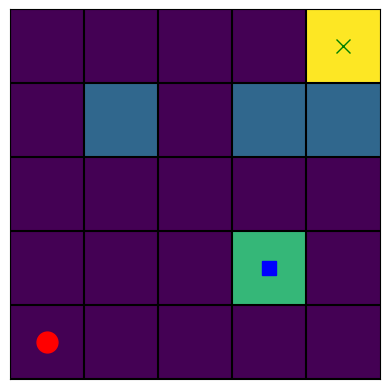

Running test: easy_map2
	Beam Search Solution:
		steps: 10, solved: True, explored states: 300, time: 0.06s, pull moves: 0
	A* Solution:
		steps: 36, solved: True, explored states: 35, time: 0.01s, pull moves: 0, backoffs: 0


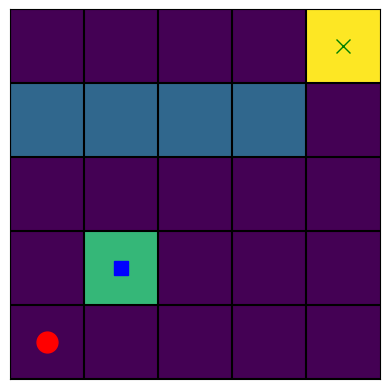

Running test: medium_map1
	Beam Search Solution:
		steps: 22, solved: True, explored states: 1183, time: 0.45s, pull moves: 0
	A* Solution:
		steps: 32, solved: True, explored states: 31, time: 0.01s, pull moves: 0, backoffs: 0


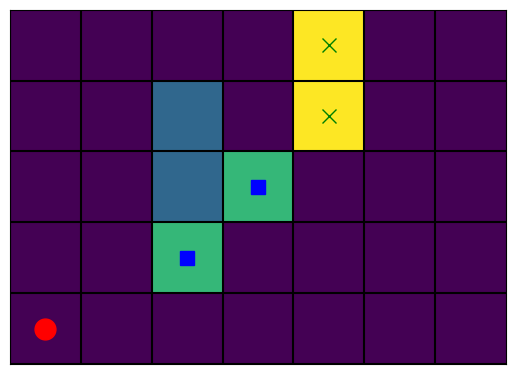

Running test: medium_map2
	Beam Search Solution:
		steps: 33, solved: True, explored states: 2100, time: 1.05s, pull moves: 0
	A* Solution:
		steps: 117, solved: True, explored states: 421, time: 0.13s, pull moves: 0, backoffs: 9


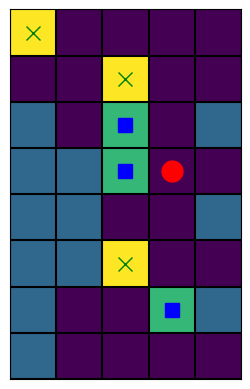

Running test: large_map1
	Beam Search Solution:
		steps: 30, solved: True, explored states: 1601, time: 1.12s, pull moves: 0
	A* Solution:
		steps: 73, solved: True, explored states: 297, time: 0.15s, pull moves: 0, backoffs: 8


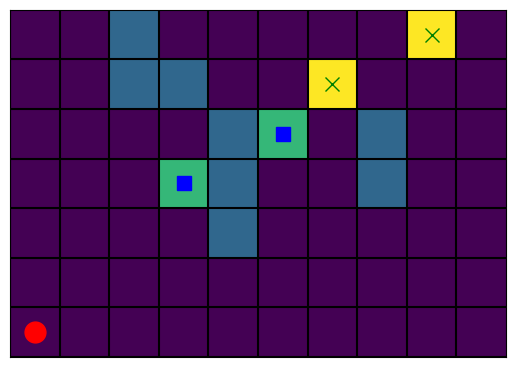

Running test: large_map2
	Beam Search Solution:
		steps: 47, solved: True, explored states: 3134, time: 4.18s, pull moves: 0
	A* Solution:
		steps: 119, solved: True, explored states: 5934, time: 4.55s, pull moves: 0, backoffs: 140


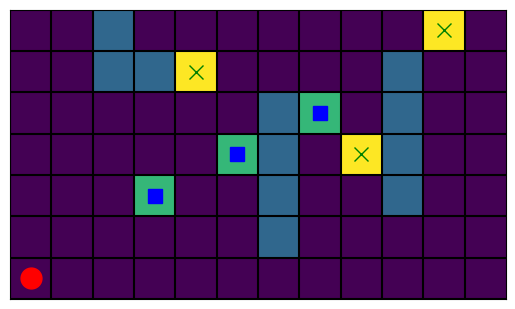

Running test: hard_map1
	Beam Search Solution:
		steps: 39, solved: True, explored states: 2655, time: 1.05s, pull moves: 0
	A* Solution:
		steps: 107, solved: True, explored states: 2239, time: 0.34s, pull moves: 0, backoffs: 62


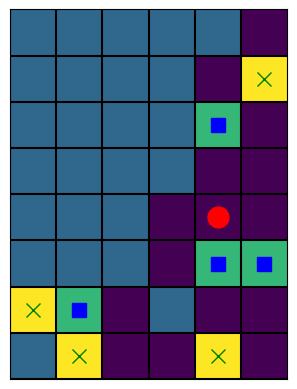

Running test: hard_map2
	Beam Search Solution:
		steps: 40, solved: True, explored states: 2541, time: 0.96s, pull moves: 0
	A* Solution:
		steps: 110, solved: True, explored states: 371, time: 0.10s, pull moves: 0, backoffs: 8


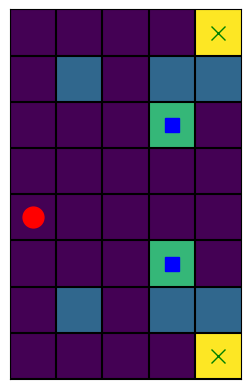

In [14]:
base_solver = Solver(
    designated_heuristic,
    state_generator,
)
beam_search_solver = BeamSearch(
    base_solver, max_iters=beam_search_max_iters, k=beam_width
)
astar_solver = LRTAstar(
    base_solver,
    max_iters=astar_max_iters,
    backoff_step_increment=backoff_step_increment,
    backoff_probability_factor=backoff_probability_factor,
    cost_plateau_treshold=cost_plateau_treshold,
)

beam_search_solutions, astar_solutions = run_tests(
    tests,
    beam_search_solver,
    astar_solver,
)

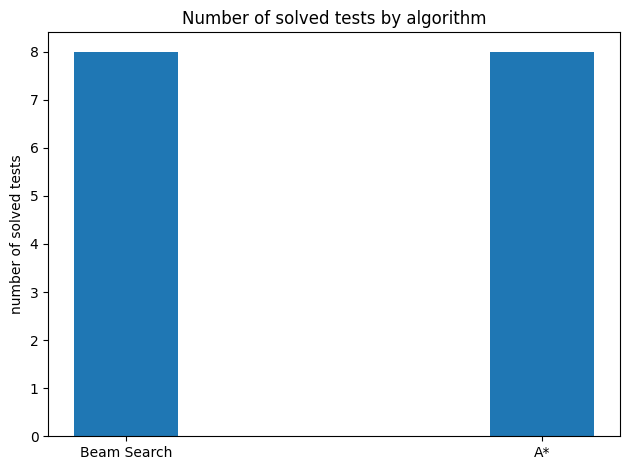

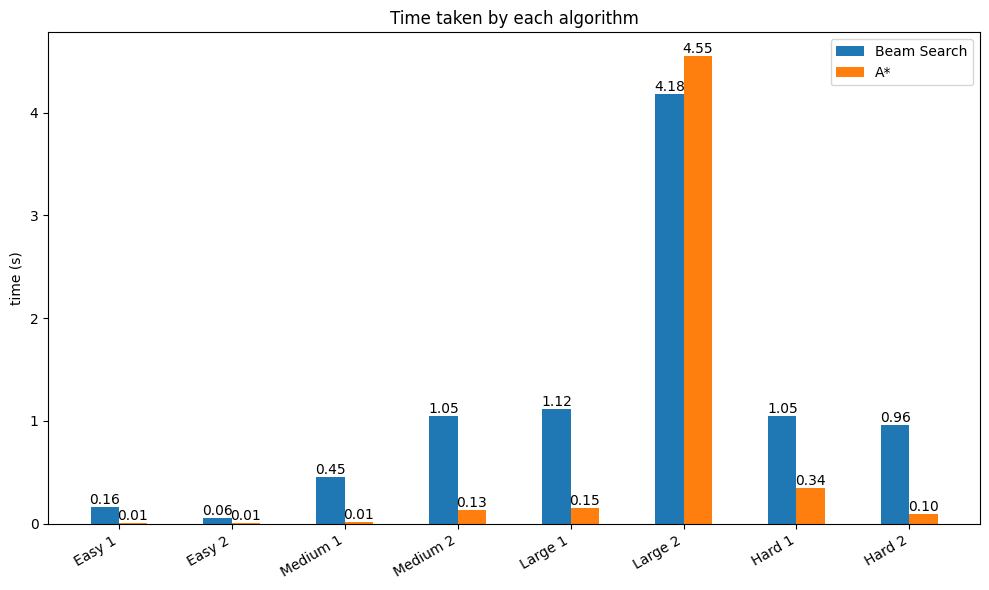

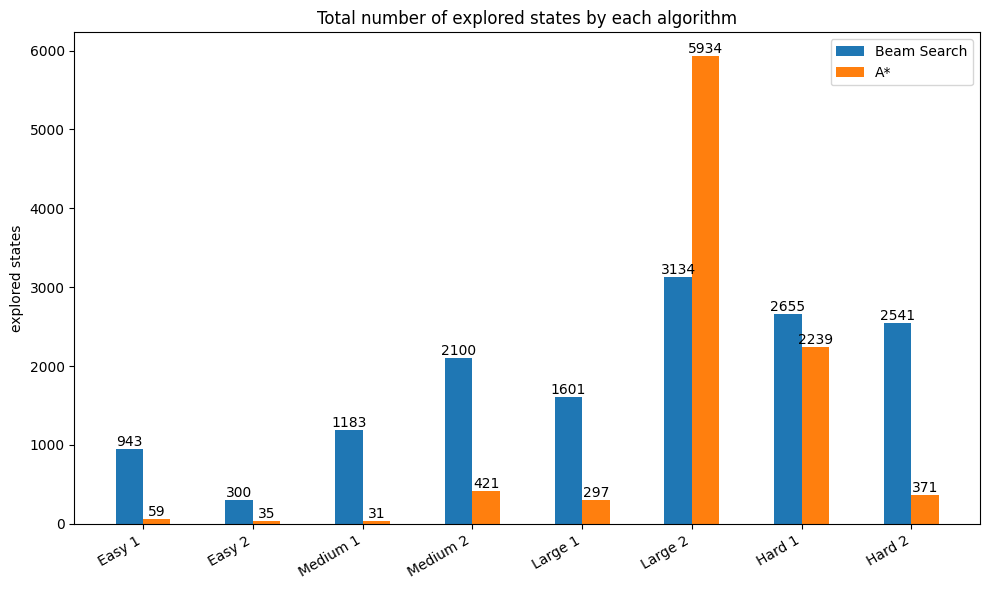

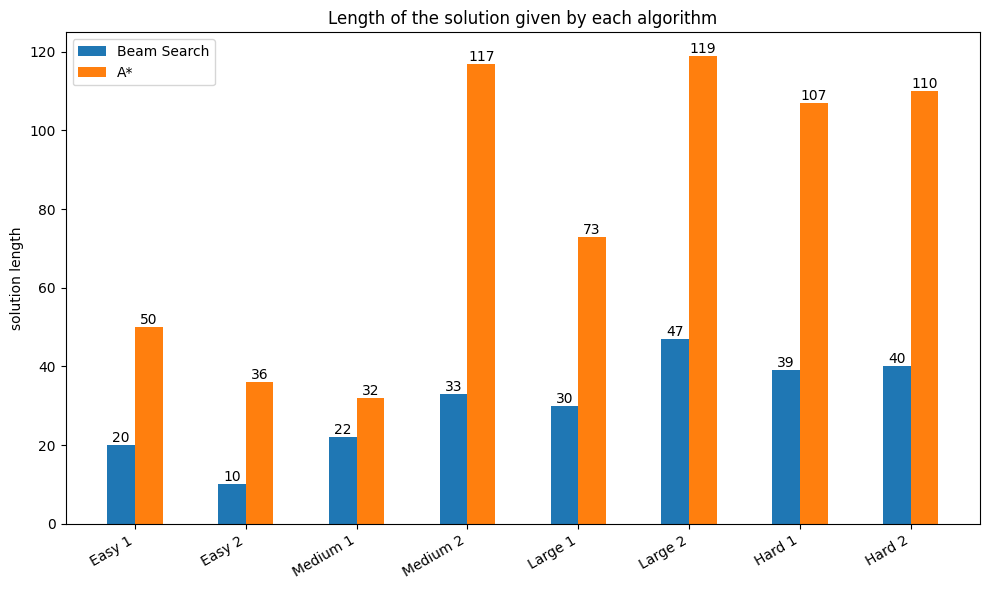

In [15]:
plot_solved_tests([beam_search_solutions, astar_solutions], ["Beam Search", "A*"])
plot_stats(test_names, [beam_search_solutions, astar_solutions], ["Beam Search", "A*"])

#### Vizualising solutions


In [16]:
# for test, solution in zip(tests, beam_search_solutions):
#     save_play(solution.steps, test, "solutions/beam_search")

# for test, solution in zip(tests, astar_solutions):
#     save_play(solution.steps, test, "solutions/lrtastar")

## Comparison


#### Compared heuristics


In [17]:
compared_heuristics = [
    heuristics.manhattan_min_distances,
    heuristics.boxes_minimum_moves_combination,
    heuristics.player_and_boxes_minimum_moves_combination,
]

heuristic_names = [
    "Manhattan dist.",
    "Boxes min moves",
    "Boxes min moves + player dist.",
]

In [18]:
beam_search_sols_by_heuristic = []
astar_solutions_by_heuristic = []

for heuristic in compared_heuristics:
    base_solver = Solver(
        heuristic,
        state_generator,
    )

    beam_search_solver = BeamSearch(
        base_solver, max_iters=beam_search_max_iters, k=beam_width
    )

    astar_solver = LRTAstar(
        base_solver,
        max_iters=astar_max_iters,
        backoff_step_increment=backoff_step_increment,
        backoff_probability_factor=backoff_probability_factor,
        cost_plateau_treshold=cost_plateau_treshold,
    )

    beam_search_solutions, astar_solutions = run_tests(
        tests, beam_search_solver, astar_solver, show_output=False
    )

    beam_search_sols_by_heuristic.append(beam_search_solutions)
    astar_solutions_by_heuristic.append(astar_solutions)

#### Beam Search heuristics comparison


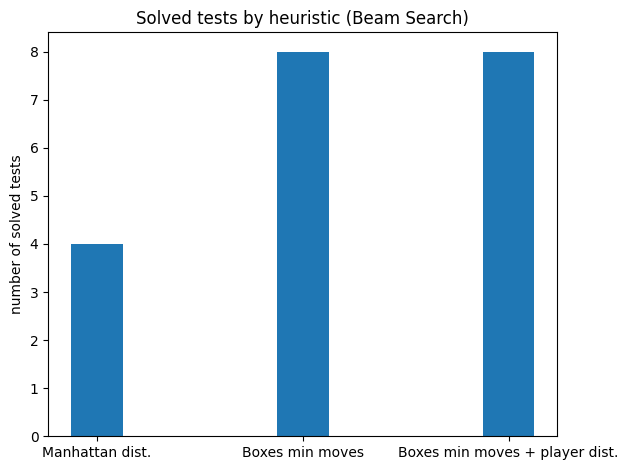

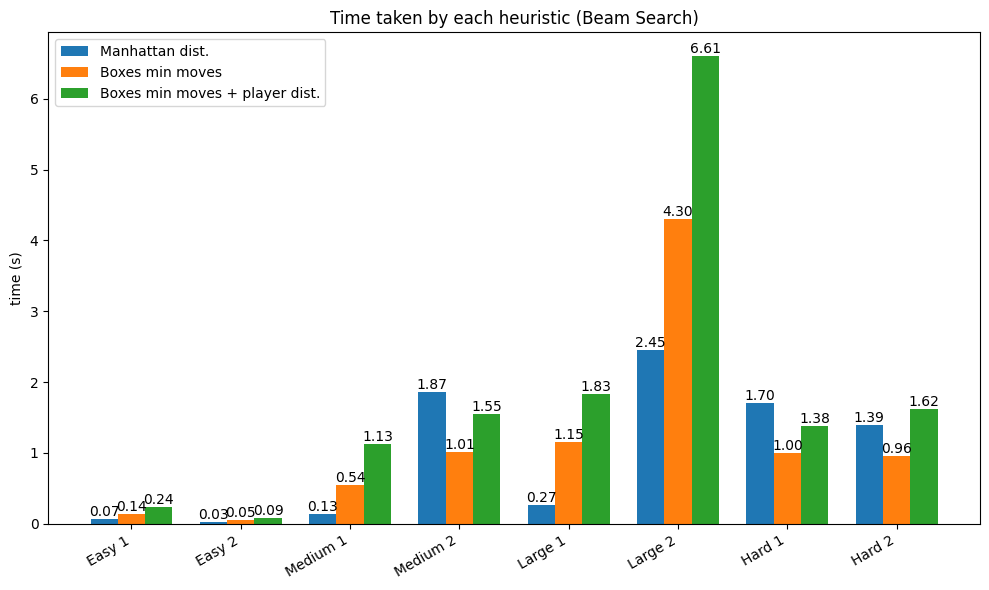

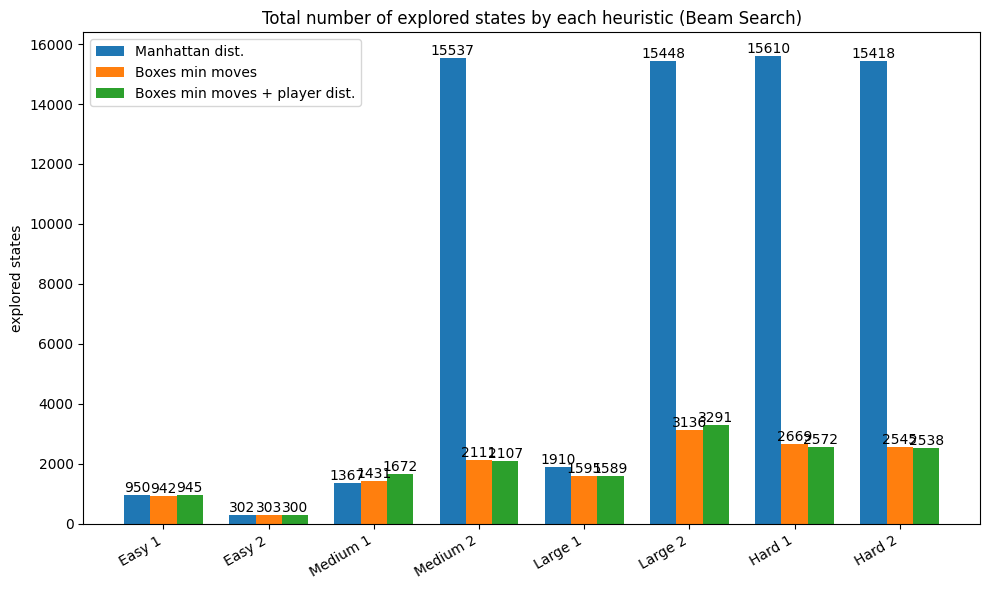

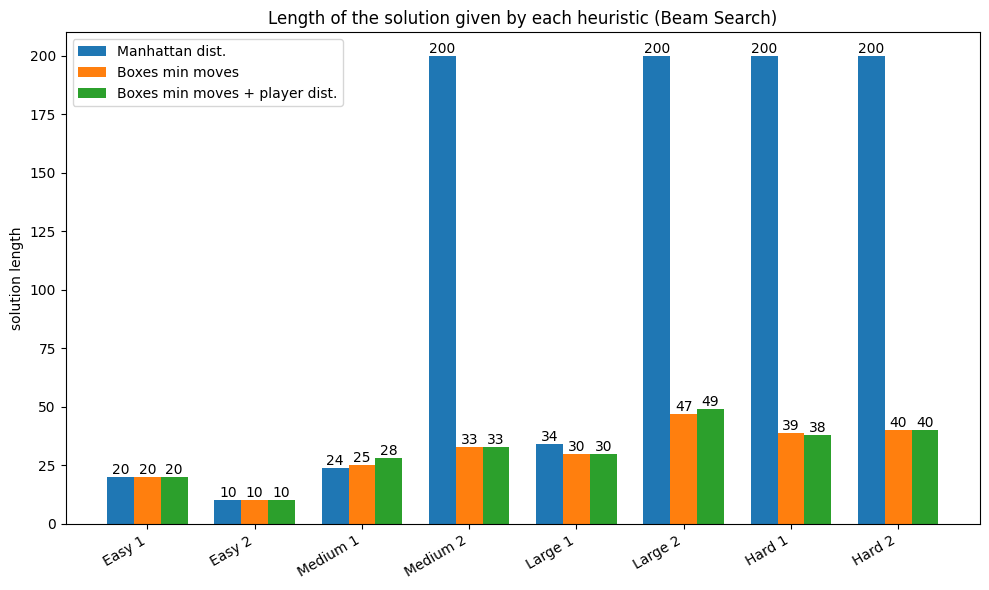

In [19]:
plot_solved_tests(
    beam_search_sols_by_heuristic,
    heuristic_names,
    "Solved tests by heuristic (Beam Search)",
)
plot_time(
    test_names,
    beam_search_sols_by_heuristic,
    heuristic_names,
    "Time taken by each heuristic (Beam Search)",
)
plot_expanded_states(
    test_names,
    beam_search_sols_by_heuristic,
    heuristic_names,
    "Total number of explored states by each heuristic (Beam Search)",
)
plot_solution_length(
    test_names,
    beam_search_sols_by_heuristic,
    heuristic_names,
    "Length of the solution given by each heuristic (Beam Search)",
)

#### LRTA\* heuristics comparison


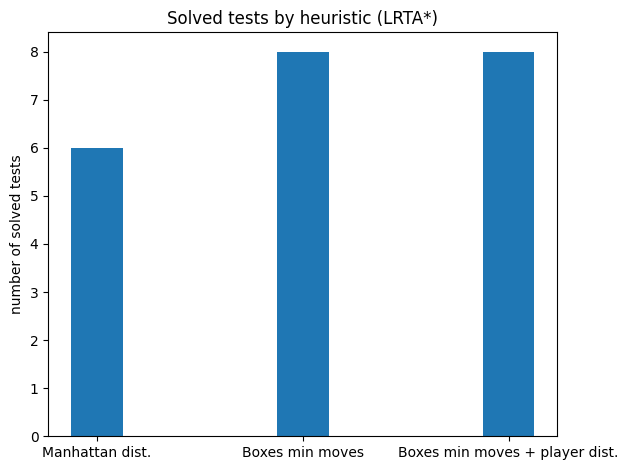

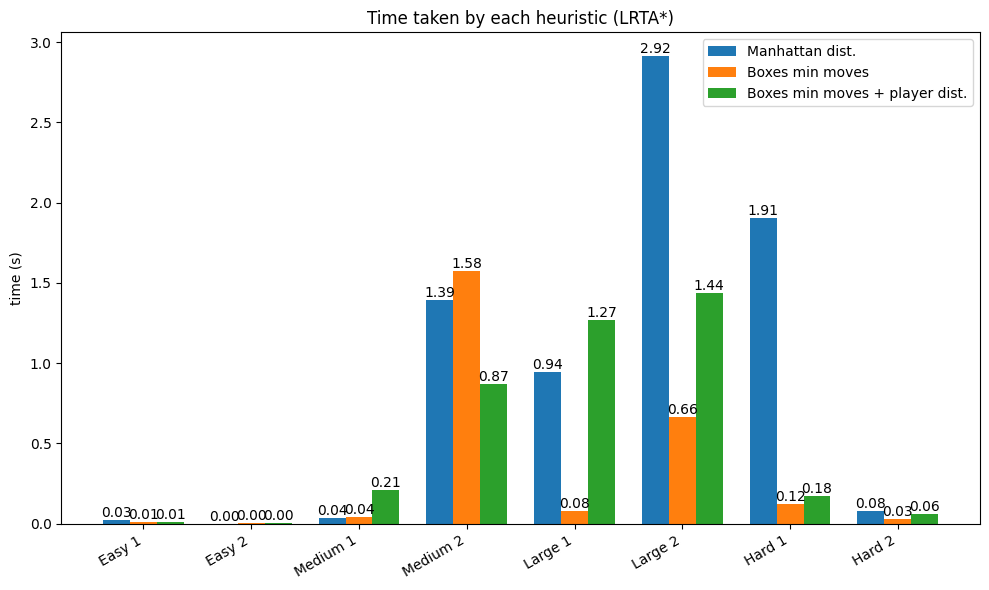

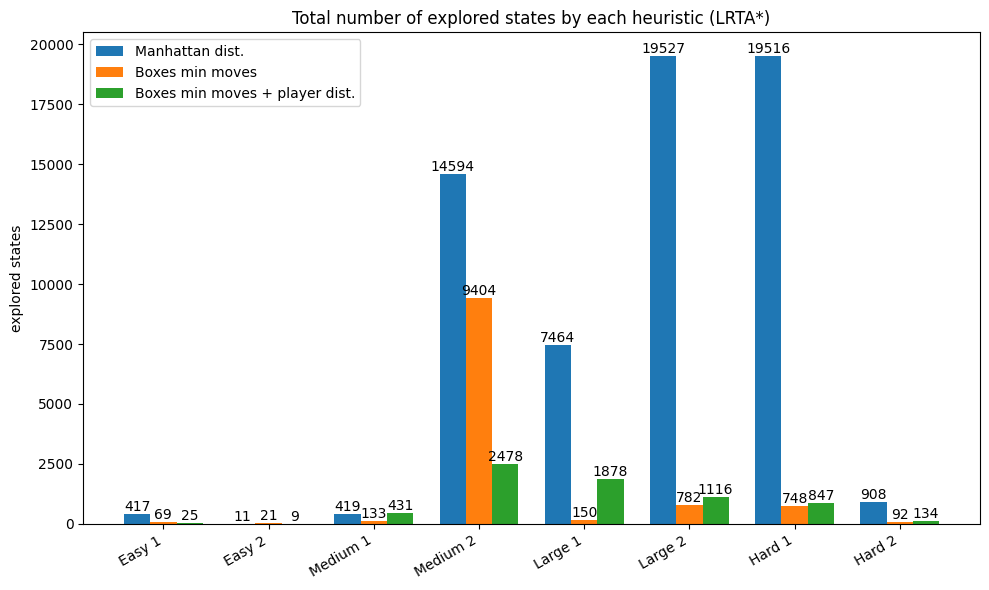

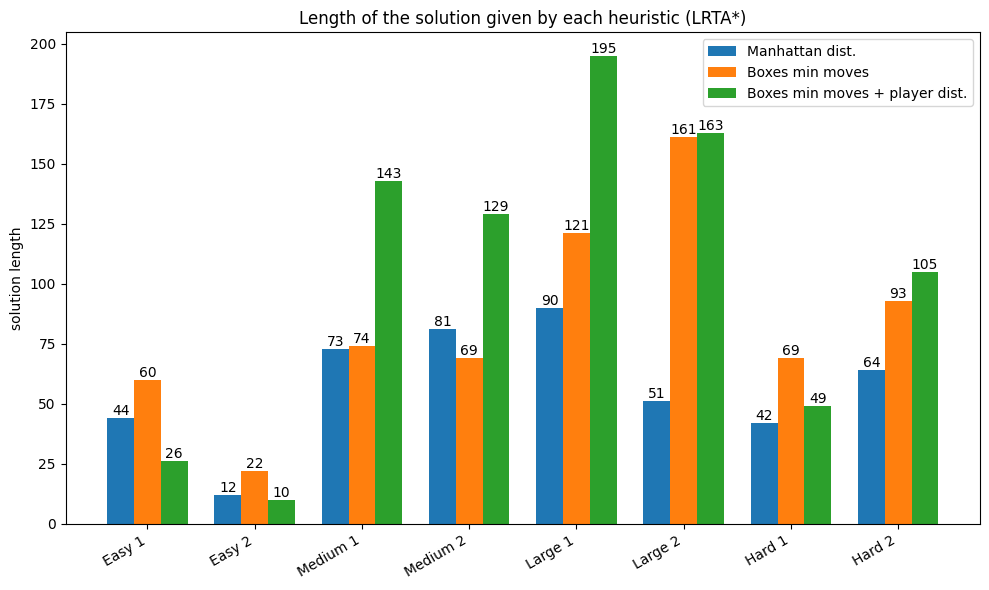

In [20]:
plot_solved_tests(
    astar_solutions_by_heuristic, heuristic_names, "Solved tests by heuristic (LRTA*)"
)
plot_time(
    test_names,
    astar_solutions_by_heuristic,
    heuristic_names,
    "Time taken by each heuristic (LRTA*)",
)
plot_expanded_states(
    test_names,
    astar_solutions_by_heuristic,
    heuristic_names,
    "Total number of explored states by each heuristic (LRTA*)",
)
plot_solution_length(
    test_names,
    astar_solutions_by_heuristic,
    heuristic_names,
    "Length of the solution given by each heuristic (LRTA*)",
)

#### Beam Search vs LRTA\* average results comparison


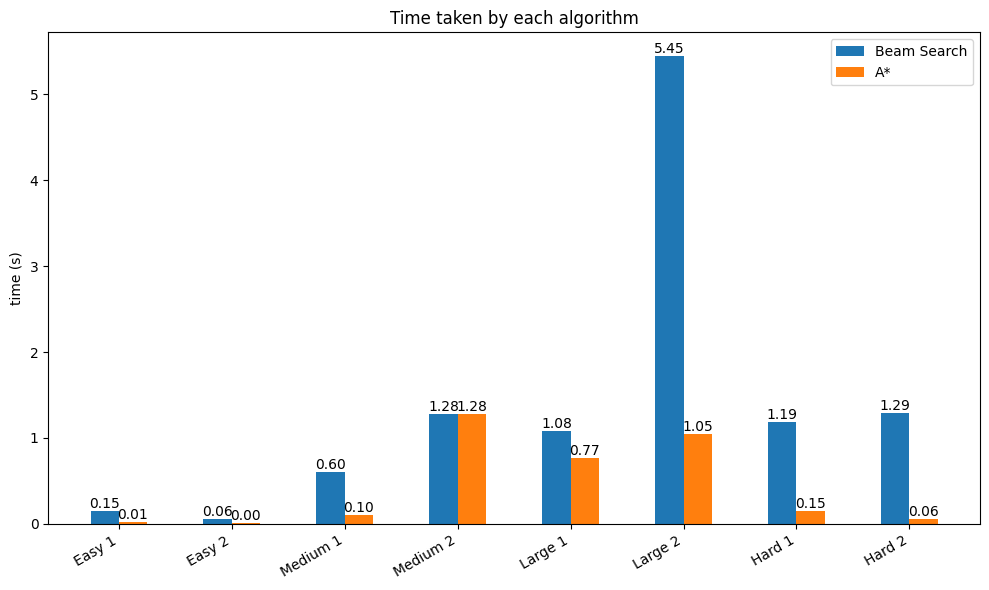

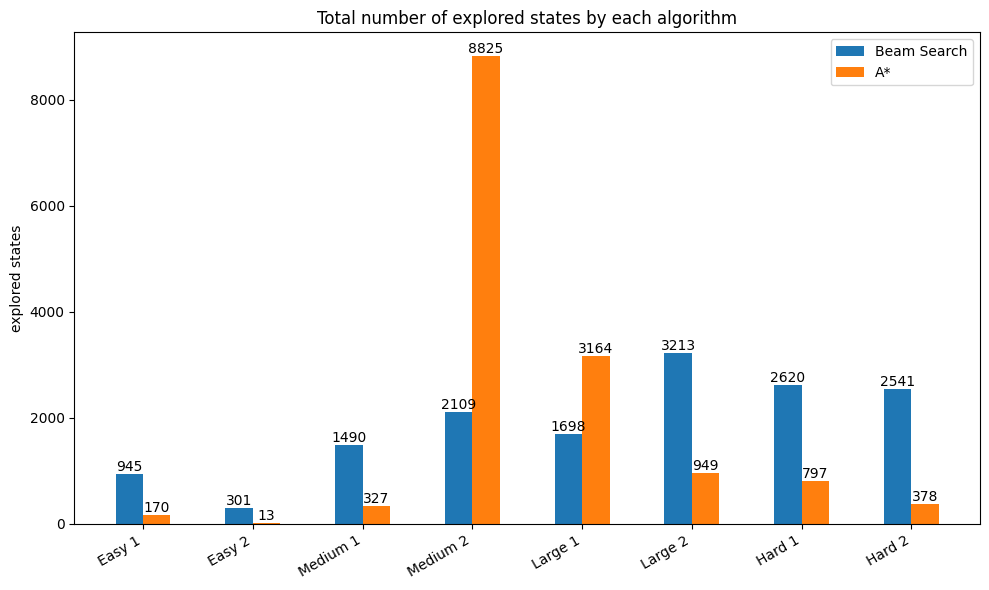

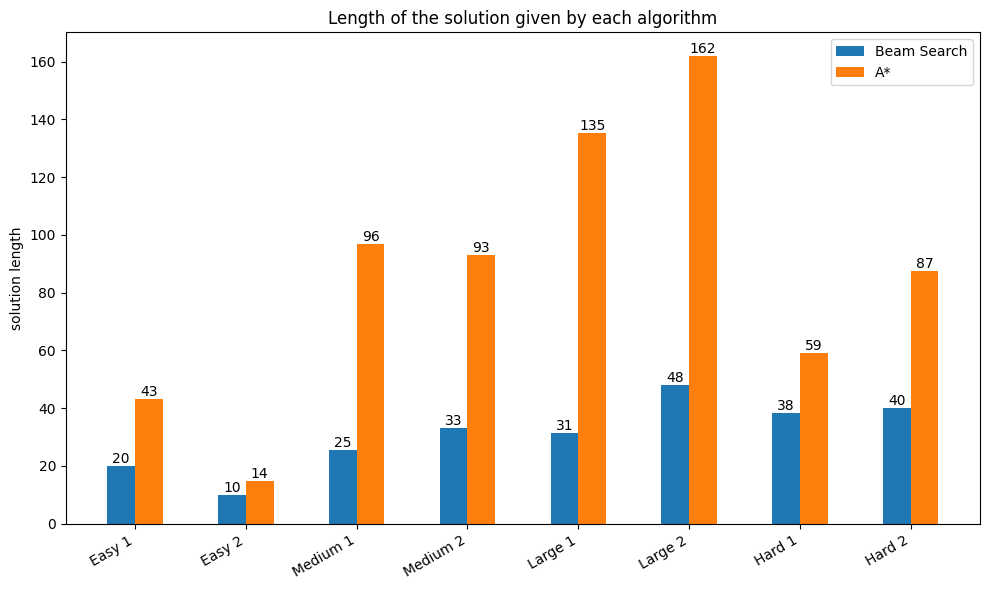

In [21]:
def transpose(xss: list[list]) -> list[list]:
    return [list(xs) for xs in zip(*xss)]


beam_search_grouped_solutions = transpose(beam_search_sols_by_heuristic)
astar_grouped_solutions = transpose(astar_solutions_by_heuristic)

beam_search_average = [
    Solution.average([sol for sol in sols if sol.is_solved()])
    for sols in beam_search_grouped_solutions
]
astar_average = [
    Solution.average([sol for sol in sols if sol.is_solved()])
    for sols in astar_grouped_solutions
]

plot_stats(
    test_names,
    [beam_search_average, astar_average],
    ["Beam Search", "A*"],
)

#### LRTA\* without backoff


In [22]:
base_solver = Solver(
    heuristics.manhattan_min_distances,
    get_neighbours,
)

astar_solver = LRTAstar(
    base_solver,
    max_iters=astar_max_iters,
    backoff_probability_factor=1.0,
)

beam_search_pulls_solutions, astar_pulls_solutions = run_tests(
    tests,
    None,
    astar_solver,
    show_output=False,
)

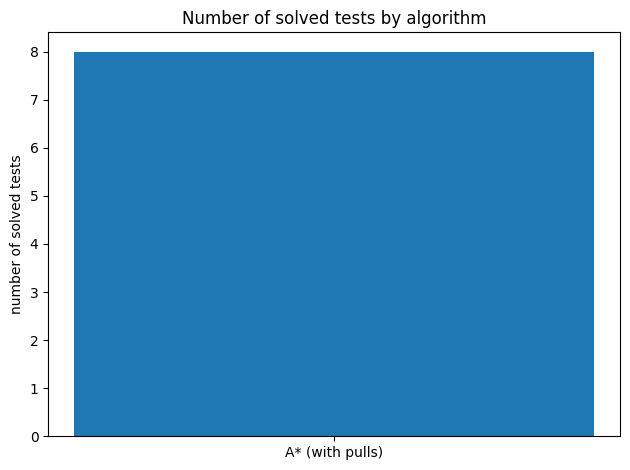

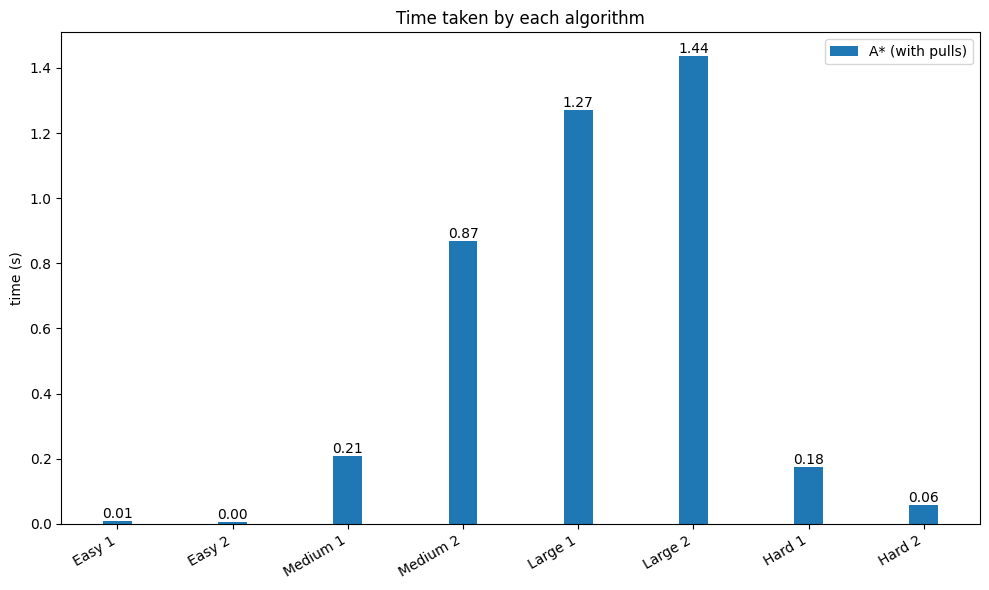

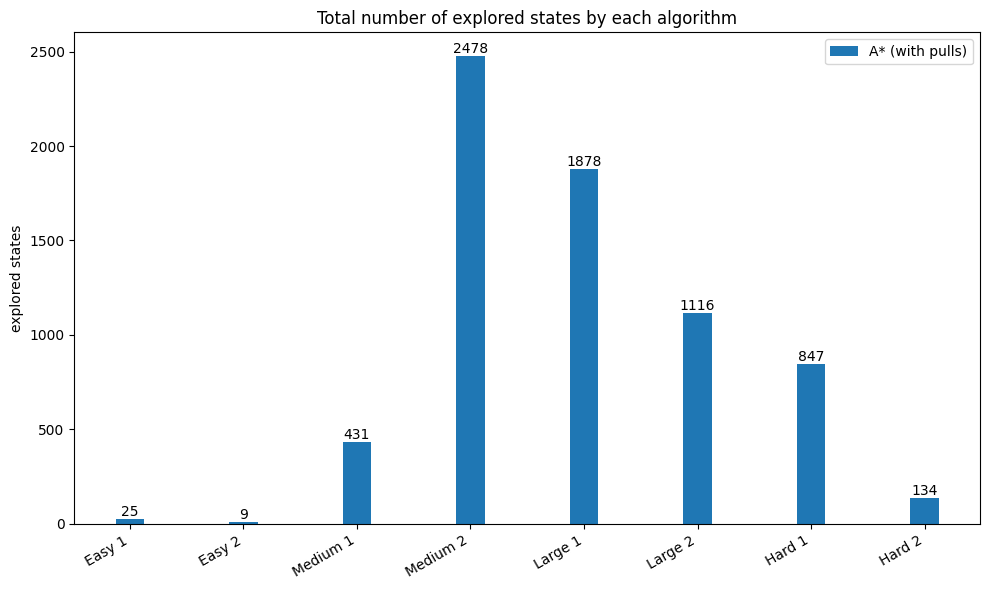

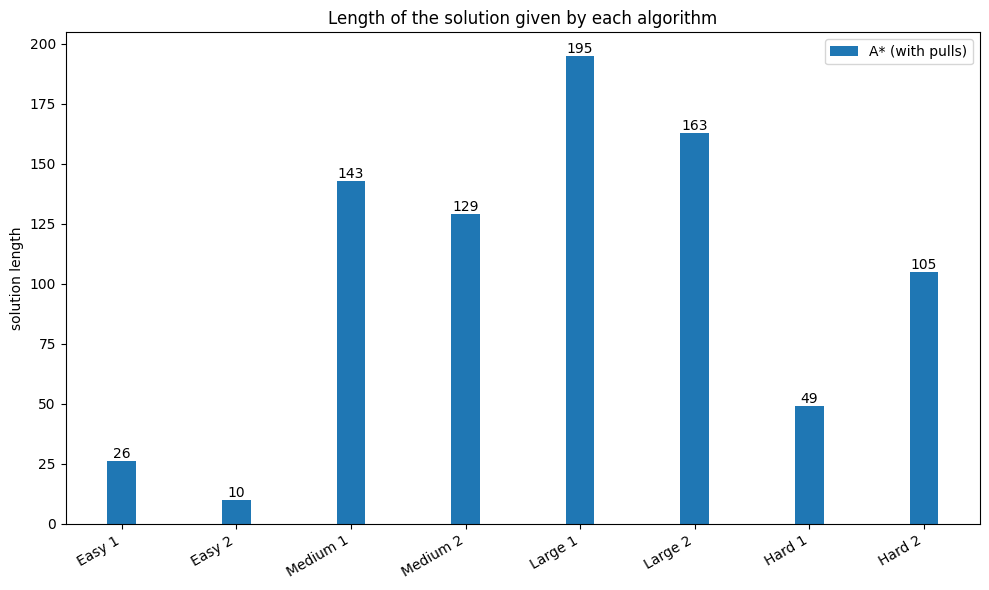

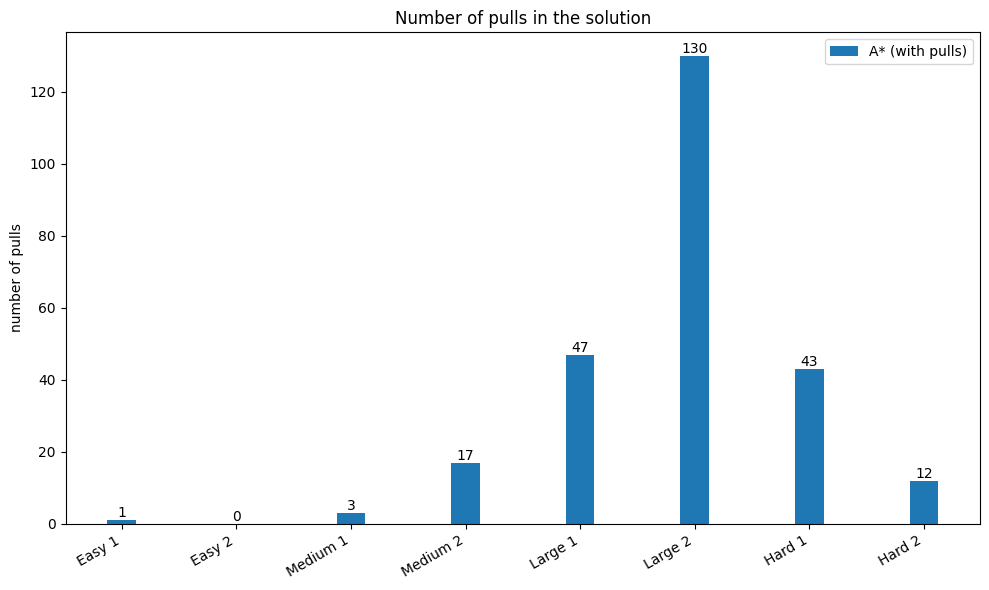

In [23]:
plot_solved_tests(
    [astar_pulls_solutions],
    ["A* (with pulls)"],
)
plot_stats(
    test_names,
    [astar_solutions],
    ["A* (with pulls)"],
)
plot_pulls(
    test_names,
    [astar_pulls_solutions],
    ["A* (with pulls)"],
    "Number of pulls in the solution",
)